# LSTM波动率预测

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
%matplotlib inline

## 读取波动率序列

In [182]:
np.random.seed(1234)
seq_len = 20

In [183]:
# fname = '../data/vix_2005_2016.csv'
# df = pd.read_csv(fname, index_col=0)
# df.index = pd.to_datetime(df.index)
# df.sort_index(inplace=True)
# vec = df['Adj Close']
# vec.head()

In [186]:
fname = '../../risk parity portfolio/data/assets.xlsx'
df = pd.read_excel(fname)
# df.sort_index(inplace=True, ascending=False)
vec = df['881001.WI'].pct_change().rolling(window=243).std().dropna() * np.sqrt(243) * 100
vec = vec[vec.index >= '2000-01-01']
vec.tail()

2019-03-21    22.883553
2019-03-22    22.877325
2019-03-25    22.583878
2019-03-26    22.660873
2019-03-27    22.620211
Name: 881001.WI, dtype: float64

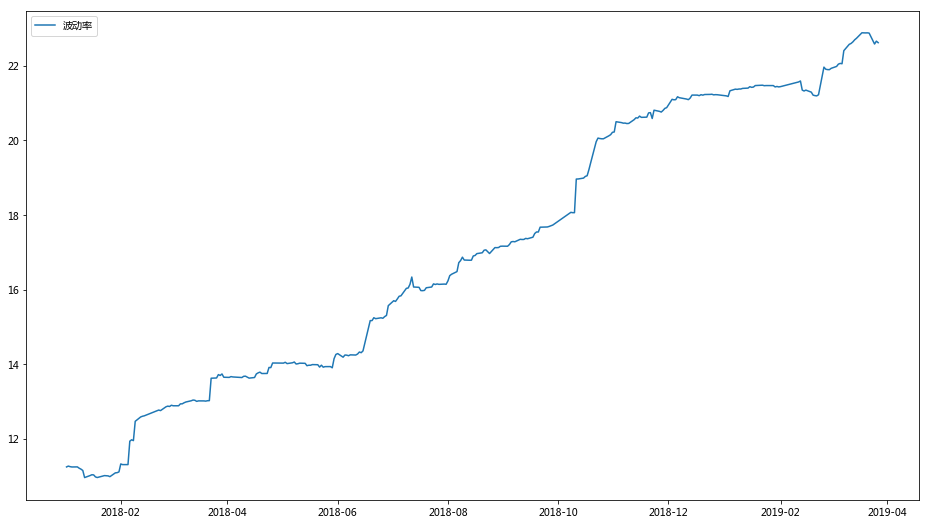

In [187]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(vec[vec.index >= '2018-01-01'], label=u'波动率')
ax.legend()

## 将序列转成矩阵
横坐标是样本点的个数，纵坐标是窗口大小

In [155]:
def series2matrix(vec, seq_len):
    matrix = []
    for i in range(vec.size - seq_len + 1):
        matrix.append(vec[i : i+seq_len])
    return np.array(matrix)

In [156]:
mat = series2matrix(vec, seq_len)

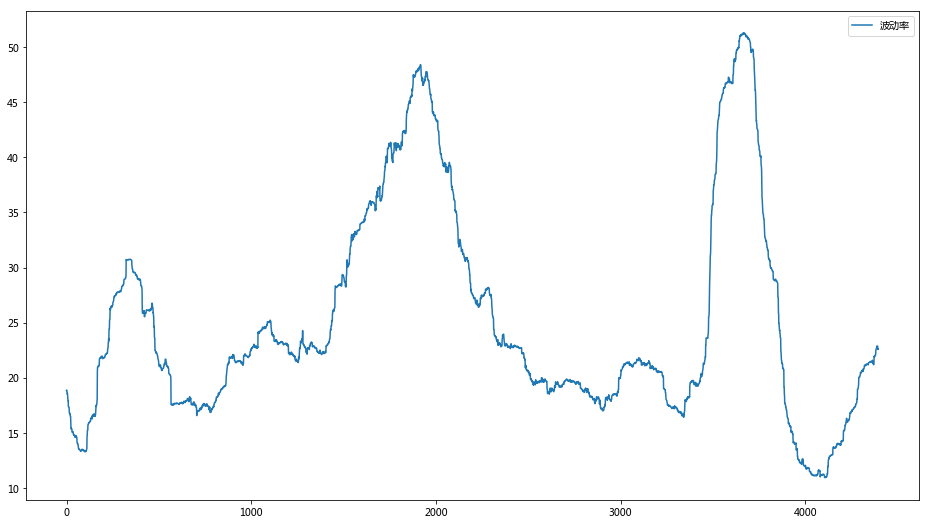

In [157]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(mat[:, -1], label=u'波动率')
ax.legend()

## 序列预处理

In [158]:
# shift all data by mean
# shifted_value = mat.mean()
# mat -= shifted_value

## 得到训练和测试样本

In [159]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * mat.shape[0]))
train_set = mat[:train_row, :].copy()
train_mean = train_set.mean(axis=1).reshape(-1, 1).copy()
train_set -= train_mean
test_set = mat[train_row:, :].copy()
test_mean = test_set.mean(axis=1).reshape(-1, 1).copy()
test_set -= test_mean

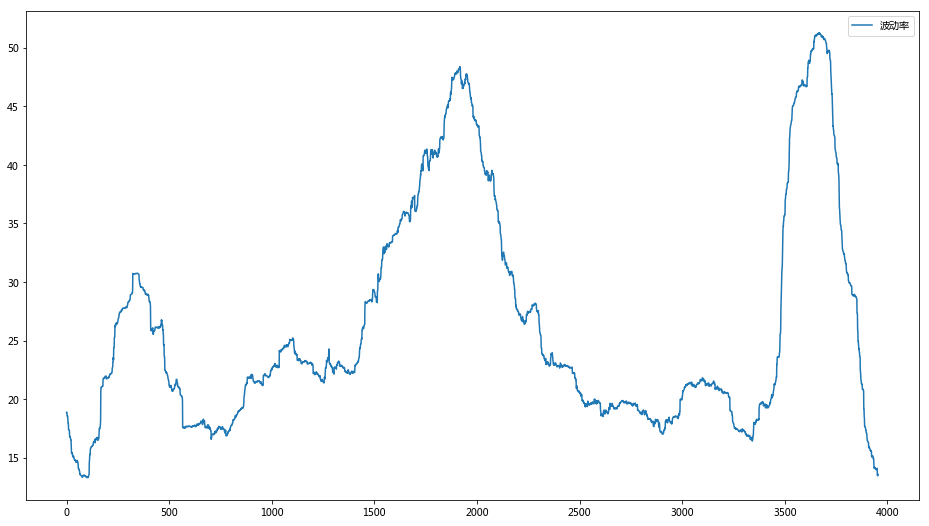

In [160]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((train_set + train_mean)[:, -1], label=u'波动率')
# ax.plot((test_set + test_mean)[:, -1], label=u'波动率')
ax.legend()

In [161]:
# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [162]:
# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [163]:
print(X_train.shape)
print(X_test.shape)

(3956, 19, 1)
(440, 19, 1)


## 构建模型

In [164]:
# build the model
model = Sequential()

In [165]:
# layer 1: LSTM
model.add(LSTM(input_shape=(None,1), units=50, return_sequences=True))
model.add(Dropout(0.2))

In [166]:
# layer 2: LSTM
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

In [167]:
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1, activation='linear'))

In [168]:
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

## 训练模型

In [169]:
# train the model
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)

Train on 3758 samples, validate on 198 samples
Epoch 1/50
3758/3758 [==============================] - 3s 837us/step - loss: 0.4442 - val_loss: 0.0925
Epoch 2/50
3758/3758 [==============================] - 1s 254us/step - loss: 0.1178 - val_loss: 0.0679
Epoch 3/50
3758/3758 [==============================] - 1s 249us/step - loss: 0.1097 - val_loss: 0.0539
Epoch 4/50
3758/3758 [==============================] - 1s 247us/step - loss: 0.0927 - val_loss: 0.0753
Epoch 5/50
3758/3758 [==============================] - 1s 248us/step - loss: 0.0872 - val_loss: 0.0636
Epoch 6/50
3758/3758 [==============================] - 1s 231us/step - loss: 0.0706 - val_loss: 0.0558
Epoch 7/50
3758/3758 [==============================] - 1s 271us/step - loss: 0.0933 - val_loss: 0.0427
Epoch 8/50
3758/3758 [==============================] - 1s 258us/step - loss: 0.0726 - val_loss: 0.0855
Epoch 9/50
3758/3758 [==============================] - 1s 271us/step - loss: 0.0705 - val_loss: 0.0573
Epoch 10/50
3758/

In [170]:
# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

440/440 [==============================] - 0s 182us/step

The mean squared error (MSE) on the test data set is 0.018 over 440 test samples.


## 测试集验证

In [171]:
# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

In [172]:
predicted_values = pd.Series(predicted_values[:, 0], index=vec.index[train_row+seq_len-1:])

In [173]:
true_values = pd.Series(y_test, index=vec.index[train_row+seq_len-1:])

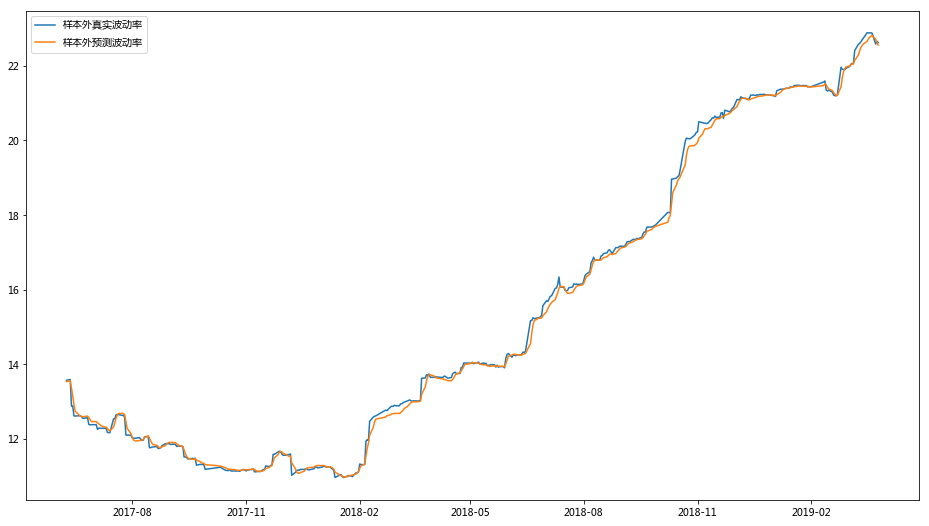

In [174]:
# plot the results
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(true_values + test_mean.reshape(-1), label=u'样本外真实波动率')
ax.plot(predicted_values + test_mean.reshape(-1), label=u'样本外预测波动率')
ax.legend()

## 未来波动率预测

In [175]:
# fut_vec = vec[-seq_len:].tolist()
# fut_vec = (predicted_values + shifted_value)[-seq_len:].tolist()
fut_vec = (predicted_values + test_mean.reshape(-1))[-seq_len:].tolist()
fut_len = 10

In [176]:
for i in range(fut_len):
    pred_vec = np.array(fut_vec[-seq_len+1:])
    matrix = pred_vec - pred_vec.mean()
#     matrix -= shifted_value
    matrix = np.reshape(matrix, (1, seq_len-1, 1))
    pred = model.predict(matrix)
    print(pred[0][0] + pred_vec.mean())
    fut_vec.append(pred[0][0] + pred_vec.mean())
#     print(pred[0][0])

22.482438545679646
22.429304837888036
22.385208026916665
22.352863348997374
22.33488717231331
22.33442901879283
22.347013695216685
22.367982441069152
22.395749407354053
22.42873276659319


In [177]:
dates = [vec.index[-1] + datetime.timedelta(i) for i in range(0, fut_len + 1)]

In [178]:
fut_seq = pd.Series(fut_vec[-(fut_len+1):], index=pd.to_datetime(dates))

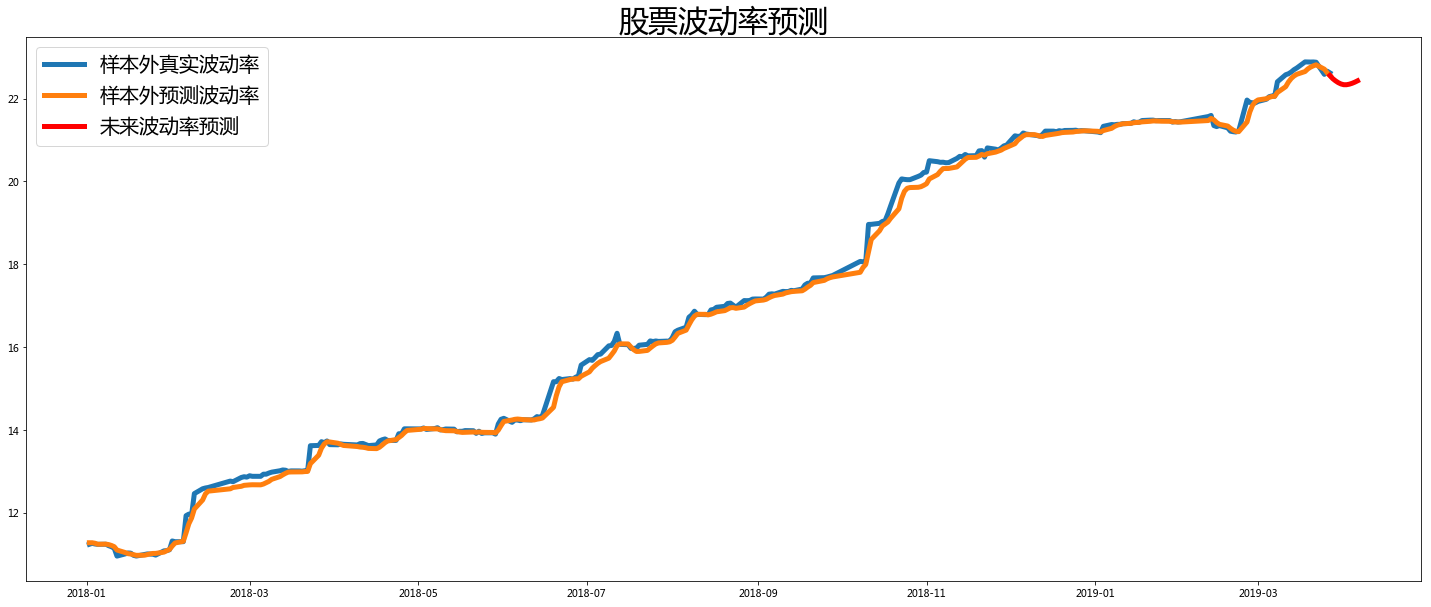

In [179]:
# plot the results
fig, ax = plt.subplots(figsize=(25, 10))
x = true_values + test_mean.reshape(-1)
y = predicted_values + test_mean.reshape(-1)
ax.plot(x[x.index >= '2018-01-01'], label=u'样本外真实波动率', linewidth=5)
ax.plot(y[y.index >= '2018-01-01'], label=u'样本外预测波动率', linewidth=5)
ax.plot(fut_seq, label=u'未来波动率预测', color='red', linewidth=5)
# ax.set_title(u'黄金波动率预测', fontsize=30)
# ax.set_title(u'债券波动率预测', fontsize=30)
ax.set_title(u'股票波动率预测', fontsize=30)
ax.legend(fontsize=20)

In [180]:
fig.savefig('../pic/volatility_prediction_stock.png', dpi=200, bbox_inches='tight')
# fig.savefig('../pic/volatility_prediction_bond.png', dpi=200, bbox_inches='tight')
# fig.savefig('../pic/volatility_prediction_commodity.png', dpi=200, bbox_inches='tight')